### Keras MLP/ RNN/ LSTM - 分析情緒
> https://ithelp.ithome.com.tw/articles/10206312


### A.直接使用keras import dataset

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd

Using TensorFlow backend.


### B.另一種匯入資料方式(需要做以下區間)
---

In [ ]:
import urllib.request
import os
import tarfile

url="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filepath="IMDb/aclImdb_v1.tar.gz"
if not os.path.isfile(filepath):
    result=urllib.request.urlretrieve(url,filepath)
    print('downloaded:',result)

#### 處理資料(將html的標籤刪除)

In [ ]:
import re
re_tag = re.compile(r'<[^>]+>')

def rm_tags(text):
    return re_tag.sub('', text)

#### 確認資料是否存在(使用另一種載入資料時才需要)

In [ ]:
import os
def read_files(filetype):
    path = "data/aclImdb/"
    file_list=[]

    positive_path=path + filetype+"/pos/"
    for f in os.listdir(positive_path):
        file_list+=[positive_path+f]
    
    negative_path=path + filetype+"/neg/"
    for f in os.listdir(negative_path):
        file_list+=[negative_path+f]
        
    print('read',filetype, 'files:',len(file_list))
       
    all_labels = ([1] * 12500 + [0] * 12500) 
    
    all_texts  = []
    
    for fi in file_list:
        with open(fi,encoding='utf8') as file_input:
            all_texts += [rm_tags(" ".join(file_input.readlines()))]
            
    return all_labels,all_texts

#### 切割訓練&測試

In [ ]:
y_train,train_text=read_files("train")

In [ ]:
y_test,test_text=read_files("test")

#### 建立字典(token)
將`文字`轉化為`數字 list`

In [ ]:
#先讀取所有文章建立dic，限制dic數量為nb_words=2500
token = Tokenizer(num_words=2500)
token.fit_on_texts(train_text)

In [ ]:
token.word_index

透過texts_to_sequences可以將訓練和測試集資料中的影評文字轉換為數字list

In [ ]:
x_train_seq = token.texts_to_sequences(train_text)
x_test_seq = token.texts_to_sequences(test_text)

#### 截長補短

maxlen設定一個句子的長度上限

In [ ]:
x_train = sequence.pad_sequences(x_train_seq, maxlen=100)
x_test  = sequence.pad_sequences(x_test_seq,  maxlen=100)

---
### 使用keras import dataset的, 以上都不用做

#### 參數設定

In [7]:
max_features = 25000
# cut texts after this number of words (among top max_features most common words)
maxlen = 100
batch_size = 10

#### Train, Test

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')

17465344/17464789 [==============================] - 27s 2us/step
25000 train sequences


#### 截長補短

In [4]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)

x_train shape: (25000, 100)


#### Embedding layer
將`數字list`轉化為`vector list`

### 1. MLP Model

In [8]:
model_MLP = Sequential()

# input length由句子長度決定, input dim由字典數決定
model_MLP.add(Embedding(output_dim=32, input_dim=max_features, input_length=100))
model_MLP.add(Dropout(0.2))

model_MLP.add(Flatten())

model_MLP.add(Dense(units=256, activation='relu' ))
model_MLP.add(Dropout(0.2))

model_MLP.add(Dense(units=1, activation='sigmoid' ))

model_MLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           800000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               819456    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 1,619,713
Trainable params: 1,619,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_MLP.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
train_history_MLP =model_MLP.fit(x_train, y_train,batch_size=100, epochs=epochs,verbose=2, validation_split=0.2)

### 2. RNN Model

### 3. LSTM Model

#### LSTM
* sigmoid 用在了各種gate上，產生0~1之間的值，這個一般只有sigmoid最直接了。
* tanh 用在了狀態和輸出上，是對數據的處理，這個用其他激活函數或許也可以。

![](https://github.com/c1mone/Tensorflow-101/blob/master/notebooks/images/11_Char_RNN/lstm_inner3.jpg?raw=true)

In [ ]:
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.summary()

### 作圖

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()

## EX02:Sine Wave

In [14]:
X_Train, Y_Train, X_Test, Y_Test = np.load('X_train.npy'), np.load('y_train.npy'), np.load('X_test.npy'), \
                                   np.load('y_test.npy')
X_Train.shape

(3501, 100, 1)

### Data為加過noise的sin波

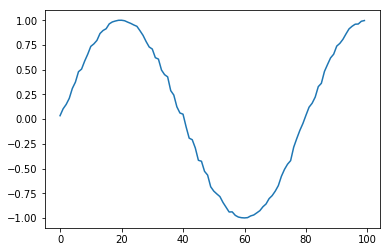

In [13]:
plt.plot(X_Train[0])

![](./img/50151313_389894408240600_5542942560080625664_n.jpg)
![](./img/50523390_380196406090325_379230223368978432_n.jpg)
![](./img/50311043_372149636696120_8973390375993475072_n.jpg)
![](./img/50407327_253654025531398_8837457100616499200_n.jpg)
![](./img/50849936_322935635230775_5743113174517809152_n.jpg)

In [15]:
inputNode = 1
outputNode = 1
# 一個node裡面會有10個cell, 讓輸出是10個數的vector
hiddenNode = 10
# recurrent 100次
warmUp = 100

In [23]:
from keras.layers.recurrent import SimpleRNN
model_RNN2 = Sequential()

# warmUp當timeStamp用, 看了100個後才predict 101, param: 11*10 + 10
model_RNN2.add(SimpleRNN(hiddenNode, input_shape=(warmUp, inputNode), return_sequences=False))

# sin wave的值域是1到-1
model_RNN2.add(Dense(outputNode, activation='tanh'))

model_RNN2.summary()

model_RNN2.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [24]:
train_history_RNN2 = model_RNN2.fit(X_Train, Y_Train, batch_size=30, epochs=10, verbose=2, validation_split=0.05)

Train on 3325 samples, validate on 176 samples
Epoch 1/10
 - 2s - loss: 0.0548 - val_loss: 0.0154
Epoch 2/10
 - 2s - loss: 0.0128 - val_loss: 0.0104
Epoch 3/10
 - 2s - loss: 0.0101 - val_loss: 0.0089
Epoch 4/10
 - 2s - loss: 0.0091 - val_loss: 0.0081
Epoch 5/10
 - 2s - loss: 0.0084 - val_loss: 0.0074
Epoch 6/10
 - 2s - loss: 0.0078 - val_loss: 0.0069
Epoch 7/10
 - 2s - loss: 0.0074 - val_loss: 0.0064
Epoch 8/10
 - 2s - loss: 0.0068 - val_loss: 0.0057
Epoch 9/10
 - 2s - loss: 0.0060 - val_loss: 0.0052
Epoch 10/10
 - 2s - loss: 0.0054 - val_loss: 0.0048


In [25]:
prediction = model_RNN2.predict(X_Test)

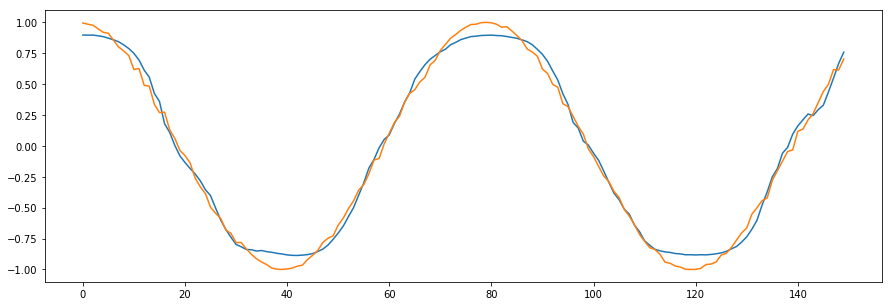

In [26]:
dataDF = pd.DataFrame(prediction[:150])
dataDF.columns = ['predict']
dataDF['input'] = Y_Test[:150]
plt.figure(figsize=(15, 5))
plt.plot(dataDF)

In [28]:
from keras.layers.recurrent import LSTM
model_LSTM2 = Sequential()

# warmUp當timeStamp用, 看了100個後才predict 101, param: 11*10 + 10
model_LSTM2.add(LSTM(hiddenNode, input_shape=(warmUp, inputNode), return_sequences=False))

# sin wave的值域是1到-1
model_LSTM2.add(Dense(outputNode, activation='tanh'))

model_LSTM2.summary()

model_LSTM2.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [31]:
train_history_LSTM2 = model_LSTM2.fit(X_Train, Y_Train, batch_size=35, epochs=10, verbose=2, validation_split=0.05)

Train on 3325 samples, validate on 176 samples
Epoch 1/10
 - 6s - loss: 0.2782 - acc: 0.0000e+00 - val_loss: 0.1059 - val_acc: 0.0000e+00
Epoch 2/10
 - 6s - loss: 0.0650 - acc: 3.0075e-04 - val_loss: 0.0279 - val_acc: 0.0000e+00
Epoch 3/10
 - 6s - loss: 0.0181 - acc: 3.0075e-04 - val_loss: 0.0121 - val_acc: 0.0000e+00
Epoch 4/10
 - 6s - loss: 0.0091 - acc: 3.0075e-04 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 5/10
 - 6s - loss: 0.0051 - acc: 3.0075e-04 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 6/10
 - 6s - loss: 0.0029 - acc: 3.0075e-04 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 7/10
 - 6s - loss: 0.0020 - acc: 3.0075e-04 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 8/10
 - 6s - loss: 0.0017 - acc: 3.0075e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 9/10
 - 6s - loss: 0.0015 - acc: 3.0075e-04 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 10/10
 - 6s - loss: 0.0013 - acc: 3.0075e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00


In [32]:
prediction2 = model_LSTM2.predict(X_Test)

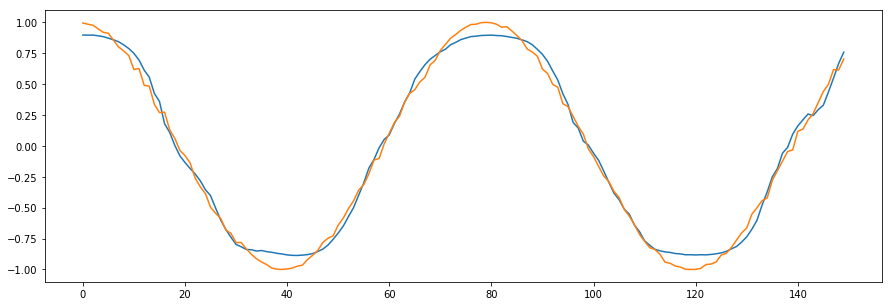

In [33]:
dataDF2 = pd.DataFrame(prediction2[:150])
dataDF2.columns = ['predict']
dataDF2['input'] = Y_Test[:150]
plt.figure(figsize=(15, 5))
plt.plot(dataDF)